In [2]:
#Imports
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import RandomizedLasso,LassoCV,LassoLarsIC
import seaborn as sns
import os

#Settin the working directory
os.chdir("C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/MAG_Strava_Daily_counts")
#Function to calcualte Variance Inflation Factor
def vif_calculation(df):
    features = "+".join(df.columns)
    y, X = dmatrices('MAG_Daily ~' + features, df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    vif = vif.round(3)
    return vif

# Function to obtain variable selection using LASSO on the chosen variables with VIF
def lasso_var_select(df,VIF_features):
    X = df[VIF_features]
    X = X[X.columns.difference(["MAG_Daily"])]
    Y = df["MAG_Daily"]
    names = X.columns
    y=0
    alpha,scores = [],[]
    model_bic = LassoLarsIC(criterion='bic')
    model_bic.fit(X, Y)
    alpha_bic_ = model_bic.alpha_
    low = alpha_bic_
    high = alpha_bic_+0.15
    steps = (high-low)/200
    for i in np.arange(low,high,steps):
        y= y+1
        rlasso = RandomizedLasso(alpha=i)
        rlasso = rlasso.fit(X, Y)
        #print(names)
        alpha.append(i)
    print(y)
    rlasso = RandomizedLasso(alpha=np.mean(alpha))
    rlasso = rlasso.fit(X, Y)
    df=pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 names), reverse=True))
    df.columns = ["Rank","Variable"]
    df["alpha"] = np.mean(alpha)
    return df

In [3]:
train_data = pd.read_csv('Strava_MAG_counts_with_covariates.csv',index_col=None)
MAG_Daily = train_data[["MAG_Daily"]]
df1 = train_data[train_data.columns.difference(['ID','Site_ID','MAG_Daily'
                                                'Count_Day','Count_Season',
                                                'Sidewalk_factor','Bike_facility',
                                                'Connectivity_to_other_segments','Diff_pct'])]
#Average Monthly Bike Counts for Maricopa from MAG data
df1 = df1.groupby(['edge_id','Count_Month'],as_index=False).mean()
vif_calculation(df1)

,VIF_Factor,features
0,669842.213,Intercept
1,1.391,edge_id
2,3.961,Count_Month
3,3.992,AADT
4,1.507,Avg_segment_speed_limit
5,5.720,Count_Day
6,7.823,EDU_ABV_HS
7,11.310,EDU_BLW_HS
8,2.588,MAG_Daily
9,6.979,MEDIAN_AGE


In [5]:
df1.columns = ['Edge id', 'Count Month', 'Avg Daily Traffic Volume', 'Avg segment speed limit', 'Count Day',
              '% Population with education above HS', '% Population with education below HS', 'MAG Counts',
              'Median age','Median household income','% Bicyclist commuters','% Non-white population',
              '% Population with no owned vehicles', '% Population with one or more vehicles', '% Population using pulic transportation',
              '% Veterans population','% Population who walk','% White Populaiton','Population per square mile',
              'Strava Counts','Distance to commercial areas','Distance to green spaces','Distance to residential areas']

In [4]:
df1.corr().to_csv("Correlation_Matrix_Strava1.csv")

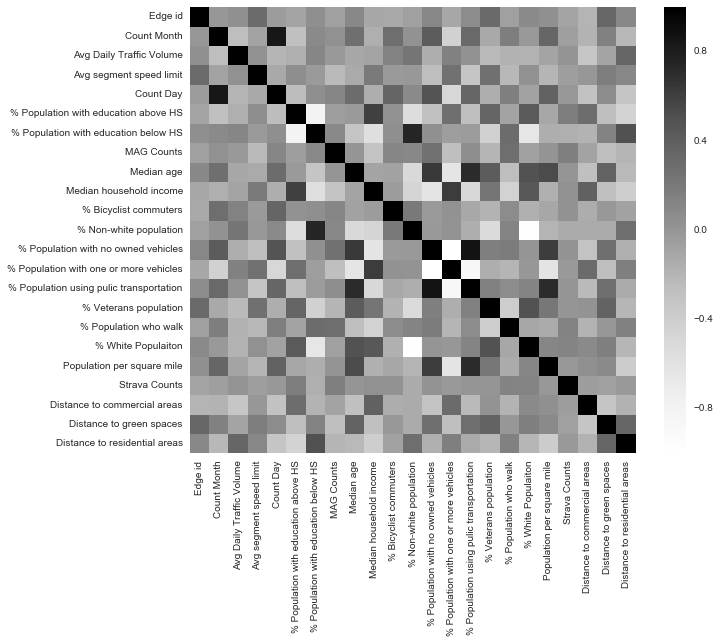

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 8))
corr = df1.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap="Greys",
            square=True, ax=ax)

In [4]:
# Removing variables that logically seem correlated
df2 = df1[df1.columns.difference(['EDU_BLW_HS','PCT_WALKED','PCT_NO_VEHICLE',
                                  'PCT_ONE_OR_MORE_VEH',
                                  'PCT_PUBLIC_TRANSPORTATION','PCT_NON_WHITE'])]
vif_calculation(df2)

,VIF_Factor,features
0,113.205,Intercept
1,2.007,AADT
2,1.382,Avg_segment_speed_limit
3,4.958,Count_Day
4,3.908,Count_Month
5,2.533,EDU_ABV_HS
6,1.683,MAG_Daily
7,2.923,MEDIAN_AGE
8,3.443,MEDIAN_HOUSEHOLD_INCOME
9,1.504,PCT_BICYCLE


In [5]:
vif_results = vif_calculation(df2)
lasso_results = lasso_var_select(train_data,vif_results.features[1:].tolist())
print(lasso_results.columns)
xlab = lasso_results.columns[0]
ylab = lasso_results.columns[1]
print(np.mean(lasso_results.alpha))
sns.set(rc={'figure.figsize':(15,10)},font_scale=2,style='white')
sns.barplot(x=xlab,y=ylab,
            data=lasso_results,color="black").figure.savefig("LASSO_Output.png",dpi=300)

/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 

/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 

/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 

/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 

/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 

/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 

/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 

200


/Users/avipsaroy/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


Index(['Rank', 'Variable', 'alpha'], dtype='object')
0.07614794582644299


In [6]:
sns.set(rc={'figure.figsize':(15,10)},font_scale=2,style='white')
sns.barplot(x=xlab,y=ylab,
            data=lasso_results,color="black").figure.savefig("LASSO_Output.png",dpi=300)

In [8]:
os.getcwd()

'/Users/avipsaroy/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/MAG_Strava_Daily_counts'

In [6]:
#Select variables with a rank above zero from LASSO output
lasso_vars = lasso_results.query("Rank>0")["Variable"].tolist()
lasso_vars.append('MAG_Daily')
#lasso_vars.append('edge_id')
lasso_vars.append('Count_Season')
df_model_input = train_data[lasso_vars].groupby(['edge_id'],as_index=False).mean()
df_model_input_seasonal = train_data[lasso_vars].groupby(['edge_id','Count_Season'],as_index=False).mean()
df_model_input["MAG_Daily"] = df_model_input.MAG_Daily.apply(lambda x: np.floor(x))
df_model_input_seasonal["MAG_Daily"] = df_model_input_seasonal.MAG_Daily.apply(lambda x: np.floor(x))
df_model_input["Strava_Daily"] = df_model_input.Strava_Daily.apply(lambda x: np.floor(x))
df_model_input_seasonal["Strava_Daily"] = df_model_input_seasonal.Strava_Daily.apply(lambda x: np.floor(x))
df_model_input_seasonal.head()

,edge_id,Count_Season,dist_to_residential_areas,dist_to_green_space,PCT_WHITE_NONHISP,MEDIAN_HOUSEHOLD_INCOME,Strava_Daily,Avg_segment_speed_limit,AADT,PCT_VETERANS,Pop_per_sq_mile,PCT_BICYCLE,dist_to_commercial_areas,MAG_Daily
0,28482,2,0.0291,0.2396,93.5463,101131.0,9.0,60.0,6586.0,13.0186,390.2826,0.0,0.0131,78.0
1,91886,2,0.0000,0.0000,51.9889,65357.0,0.0,50.0,8979.0,4.1068,11881.6563,0.0,0.1450,59.0
2,117232,3,0.0146,0.4039,87.2398,96607.0,5.0,70.0,12418.5,12.5227,1261.8032,0.0,0.2016,47.0
3,126839,2,0.0016,0.0000,38.2376,40208.0,1.0,40.0,10039.0,3.0093,3219.7848,0.0,0.1887,50.0
4,126839,3,0.0016,0.0000,38.2376,40208.0,0.0,40.0,10039.0,3.0093,3219.7848,0.0,0.1887,46.0


In [7]:
#Write Outputs to Files
os.chdir("C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/LASSO Results")
lasso_results.to_csv("LASSO_Output_May21_run1.csv")
os.chdir("C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/Model Input")
df_model_input.to_csv("GLM_Model_Input_May21_run1_annual.csv")
df_model_input_seasonal.to_csv("GLM_Model_Input_May21_run1_seasonal.csv")

In [1]:
#Function to run Generalized Linear Model on LASSO Features
require(glmnet)
require(boot)
glm_output <- function(train,test){
    predictors = train[,which(names(train)!="MAG_Daily")]
    #str(predictors)
    features = model.matrix(~.,predictors)
    newx = model.matrix(~.,test[,which(names(test)!="MAG_Daily")])
    target = matrix(train$MAG_Daily)
    cvfit <- cv.glmnet(y = target, x = features, family="poisson",nfolds = 100,alpha=1)
    cvlambda = cvfit$lambda
    cverror = cvfit$cvm
    plot(cvfit)
    lmin  <- cvfit$lambda.min
    l1se  <- cvfit$lambda.1se
    model.glmnet <- glmnet(y = target, x = features, family="poisson")
    #print(summary(model.glmnet))
    print(exp(coef(model.glmnet, s = lmin)))
    print(paste("Lambda for min Cross-validation error:", lmin))
    Predicted_Counts=predict(model.glmnet, newx, s=lmin, type = "response")
    return(Predicted_Counts)
}

#Function to calculate root mean squared error after k-fold cross-validation
options(warn=-1)
rmse_calc <- function(y,yhat) {return(sqrt(sum((y-yhat)^2)))}
model_error <- function(train_data){
    j=1
    score=c()
    train_size=c()
    rmse=c()
    test_size=c()
    set.seed(100)
    for (i in seq(0.15,0.95,0.0005))
        {
        sample = sample.int(n = nrow(train_data), size = floor(i*nrow(train_data)), replace = F)
        train_x = train_data[sample,-c(1,2,3,8,11)]
        test_x = train_data[-sample,-c(1,2,3,8,11)]
        true_Counts = train_data$MAG_Daily
        model = glm(MAG_Daily~.,data=train_x,family=poisson(link=log))
        cvfit = cv.glm(train_x,model,K=10)
        yhat = predict(model,test_x,type="response")
        #test$predicted = yhat
        score[j] = cvfit$delta[1]
        train_size[j] = i
        test_size[j] = 1-i
        rmse[j] = rmse_calc(test_x$MAG_Daily,yhat[1])
        j = j+1
        }
    errordf = data.frame(score,rmse,train_size,test_size)
    accuracy = function(x){1-(x/max(errordf$rmse))}
    errordf$rmse_pct = lapply(errordf$rmse,accuracy)
    return(errordf)
    }

Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13

Loading required package: boot


In [3]:
library(boot)
setwd("/Users/avipsaroy/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/Model Input")
train_data1 = read.csv("GLM_Model_Input_May21_run1_annual.csv")
str(train_data1)

'data.frame':	338 obs. of  15 variables:
 $ X                        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ edge_id                  : int  28482 91886 117232 126839 129694 129695 133980 375523 375524 379692 ...
 $ dist_to_residential_areas: num  0.0291 0 0.0146 0.0016 0 ...
 $ dist_to_green_space      : num  0.24 0 0.404 0 0.204 ...
 $ PCT_WHITE_NONHISP        : num  93.5 52 87.2 38.2 51.1 ...
 $ MEDIAN_HOUSEHOLD_INCOME  : num  101131 65357 96607 40208 41220 ...
 $ Strava_Daily             : num  9 0 5 1 3 4 3 0 1 1 ...
 $ Avg_segment_speed_limit  : num  60 50 70 40 40 40 40 64 64 40 ...
 $ AADT                     : num  6586 8979 12418 10039 16901 ...
 $ PCT_VETERANS             : num  13.02 4.11 12.52 3.01 4.8 ...
 $ Pop_per_sq_mile          : num  390 11882 1262 3220 4564 ...
 $ PCT_BICYCLE              : num  0 0 0 0 5.99 ...
 $ dist_to_commercial_areas : num  0.0131 0.145 0.2016 0.1887 0 ...
 $ MAG_Daily                : num  78 59 47 49 55 55 55 55 56 18 ...
 $ Count_Season         

In [8]:
tail(train_data2)

,X,edge_id,Count_Season,dist_to_residential_areas,dist_to_green_space,PCT_WHITE_NONHISP,MEDIAN_HOUSEHOLD_INCOME,Strava_Daily,Avg_segment_speed_limit,AADT,PCT_VETERANS,Pop_per_sq_mile,PCT_BICYCLE,dist_to_commercial_areas
432,431,930488,1,0.0642,0.1390,91.8468,96250,1,5,22641.0,17.2932,5809.485,0,0.0832
433,432,936289,2,0.0225,0.2884,30.2387,60250,2,15,10162.0,4.9236,5063.217,0,0.0210
434,433,940745,3,0.0146,0.4039,87.2398,96607,4,70,12418.5,12.5227,1261.803,0,0.2016
435,434,950776,1,0.0253,0.0000,78.3924,58607,9,15,26376.0,3.2926,4828.247,0,0.0254
436,435,950777,1,0.0253,0.0000,78.3924,58607,15,15,26376.0,3.2926,4828.247,0,0.0254
437,436,959483,1,0.0000,0.0124,8.3784,15564,0,15,0.0,1.9973,2948.656,0,0.0000


In [4]:
train_data2 = read.csv("GLM_Model_Input_May21_run1_seasonal.csv")
str(train_data1)

'data.frame':	338 obs. of  15 variables:
 $ X                        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ edge_id                  : int  28482 91886 117232 126839 129694 129695 133980 375523 375524 379692 ...
 $ dist_to_residential_areas: num  0.0291 0 0.0146 0.0016 0 ...
 $ dist_to_green_space      : num  0.24 0 0.404 0 0.204 ...
 $ PCT_WHITE_NONHISP        : num  93.5 52 87.2 38.2 51.1 ...
 $ MEDIAN_HOUSEHOLD_INCOME  : num  101131 65357 96607 40208 41220 ...
 $ Strava_Daily             : num  9 0 5 1 3 4 3 0 1 1 ...
 $ Avg_segment_speed_limit  : num  60 50 70 40 40 40 40 64 64 40 ...
 $ AADT                     : num  6586 8979 12418 10039 16901 ...
 $ PCT_VETERANS             : num  13.02 4.11 12.52 3.01 4.8 ...
 $ Pop_per_sq_mile          : num  390 11882 1262 3220 4564 ...
 $ PCT_BICYCLE              : num  0 0 0 0 5.99 ...
 $ dist_to_commercial_areas : num  0.0131 0.145 0.2016 0.1887 0 ...
 $ MAG_Daily                : num  78 59 47 49 55 55 55 55 56 18 ...
 $ Count_Season         

In [5]:
#Using LASSO variables from the training data to fit a Poisson model on daily counts
test_data = read.csv("TBAG_Strava_Counts_with_Covariates.csv")
str(test_data)

'data.frame':	47296 obs. of  25 variables:
 $ X                             : int  0 1 2 3 4 5 6 7 8 9 ...
 $ edge_id                       : int  381576 381576 381576 381576 381576 381576 381576 381576 381576 381576 ...
 $ tbag_loc_id                   : int  101 101 101 101 101 101 101 101 101 101 ...
 $ Day                           : int  91 91 91 91 91 91 91 91 91 91 ...
 $ Month                         : int  3 3 3 3 3 3 3 3 3 3 ...
 $ Season                        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ AADT                          : int  33902 33902 33902 33902 33902 33902 33902 33902 33902 33902 ...
 $ Avg_segment_speed_limit       : int  48 48 48 48 48 48 48 48 48 48 ...
 $ Connectivity_to_other_segments: num  5 5 5 5 5 5 5 5 5 5 ...
 $ dist_to_commercial_areas      : num  0.049 0.049 0.049 0.049 0.049 0.049 0.049 0.049 0.049 0.049 ...
 $ dist_to_green_space           : num  0.028 0.028 0.028 0.028 0.028 0.028 0.028 0.028 0.028 0.028 ...
 $ dist_to_residential_areas     : num  0.4

In [6]:
test_data = as.data.frame(aggregate(.~edge_id,data=test_data[,-c(4:6,9,16,18,21,23:25)],FUN=mean,na.rm=TRUE))
str(test_data)

'data.frame':	167 obs. of  15 variables:
 $ edge_id                  : int  73 74 88 89 106 107 108 116 17432 36743 ...
 $ X                        : num  27072 27328 25792 26304 30208 ...
 $ tbag_loc_id              : num  130 130 128 128 145 172 172 129 119 118 ...
 $ AADT                     : num  2771 8735 24936 88072 19638 ...
 $ Avg_segment_speed_limit  : num  50 50 50 50 40 40 40 40 50 70 ...
 $ dist_to_commercial_areas : num  0.24 0.24 0.045 0.045 0 0.004 0.004 0 0.173 0.025 ...
 $ dist_to_green_space      : num  0.195 0.195 0.405 0.405 1.305 ...
 $ dist_to_residential_areas: num  0 0 0.006 0.006 0.05 0 0 0.01 0.172 0.133 ...
 $ Strava_Daily             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MAG_Daily                : num  0 0 1 1 0 4 4 4 4 9 ...
 $ Pop_per_sq_mile          : num  2582 2582 11238 11238 7388 ...
 $ PCT_WHITE_NONHISP        : num  91.5 91.5 47.6 47.6 72.7 ...
 $ PCT_VETERANS             : num  10.96 10.96 4.06 4.06 7.77 ...
 $ MEDIAN_HOUSEHOLD_INCOME  : num  68125 68

In [7]:
#Poisson Fit for seasonal counts
train_data2$Count_Season = as.factor(train_data2$Count_Season)
model1 = glm(MAG_Daily~.,data=train_data2,family=poisson(link=log))
summary(model1)


Call:
glm(formula = MAG_Daily ~ ., family = poisson(link = log), data = train_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-12.290   -3.731   -1.301    1.877   17.797  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                4.511e+00  5.307e-02  84.987  < 2e-16 ***
X                         -2.902e-03  1.435e-04 -20.221  < 2e-16 ***
edge_id                    1.680e-06  9.144e-08  18.368  < 2e-16 ***
Count_Season2             -2.321e-02  1.511e-02  -1.536    0.125    
Count_Season3             -4.651e-01  1.997e-02 -23.284  < 2e-16 ***
dist_to_residential_areas -4.215e+00  7.694e-02 -54.783  < 2e-16 ***
dist_to_green_space       -8.812e-01  5.092e-02 -17.305  < 2e-16 ***
PCT_WHITE_NONHISP          1.477e-02  4.773e-04  30.947  < 2e-16 ***
MEDIAN_HOUSEHOLD_INCOME   -2.515e-05  3.045e-07 -82.600  < 2e-16 ***
Strava_Daily               3.372e-02  2.128e-03  15.846  < 2e-16 ***
Avg_segment_speed_limit   

In [8]:
#Negative Binomial Fit for seasonal counts
library(MASS)
model2 = glm.nb(MAG_Daily~.,data=train_data2)
summary(model2)


Call:
glm.nb(formula = MAG_Daily ~ ., data = train_data2, init.theta = 2.982629998, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2590  -0.7512  -0.3388   0.1724   3.0660  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                4.691e+00  2.512e-01  18.671  < 2e-16 ***
X                         -2.177e-03  6.711e-04  -3.244 0.001178 ** 
edge_id                    1.239e-06  4.385e-07   2.825 0.004734 ** 
Count_Season2              1.742e-01  8.076e-02   2.157 0.030989 *  
Count_Season3             -2.494e-01  8.852e-02  -2.818 0.004838 ** 
dist_to_residential_areas -3.537e+00  2.939e-01 -12.035  < 2e-16 ***
dist_to_green_space       -3.236e-01  1.931e-01  -1.675 0.093840 .  
PCT_WHITE_NONHISP          1.493e-02  2.166e-03   6.895 5.37e-12 ***
MEDIAN_HOUSEHOLD_INCOME   -2.294e-05  1.473e-06 -15.566  < 2e-16 ***
Strava_Daily               4.182e-02  1.234e-02   3.388 0.000704 ***
Avg_segmen

In [9]:
#Poisson Fit for Annual Counts
model3 = glm(MAG_Daily~.,data=train_data1[,-c(15)],family=poisson(link=log))
summary(model3)


Call:
glm(formula = MAG_Daily ~ ., family = poisson(link = log), data = train_data1[, 
    -c(15)])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-12.059   -4.011   -1.121    2.125   14.666  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                4.140e+00  5.927e-02  69.859  < 2e-16 ***
X                         -4.588e-03  2.402e-04 -19.101  < 2e-16 ***
edge_id                    1.934e-06  1.144e-07  16.908  < 2e-16 ***
dist_to_residential_areas -3.494e+00  8.624e-02 -40.517  < 2e-16 ***
dist_to_green_space       -1.480e+00  5.735e-02 -25.813  < 2e-16 ***
PCT_WHITE_NONHISP          1.747e-02  5.396e-04  32.380  < 2e-16 ***
MEDIAN_HOUSEHOLD_INCOME   -2.329e-05  3.422e-07 -68.053  < 2e-16 ***
Strava_Daily               3.625e-02  2.166e-03  16.742  < 2e-16 ***
Avg_segment_speed_limit   -1.962e-03  3.091e-04  -6.348 2.18e-10 ***
AADT                       1.919e-05  8.275e-07  23.195  < 2e-16 ***
PCT_VETERAN

In [10]:
#Negative Binomial Fit for annual counts
model4 = glm.nb(MAG_Daily~.,data=train_data1[,-c(15)])
summary(model4)


Call:
glm.nb(formula = MAG_Daily ~ ., data = train_data1[, -c(15)], 
    init.theta = 2.769463987, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2220  -0.7862  -0.3637   0.3600   2.7214  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                4.453e+00  2.870e-01  15.520  < 2e-16 ***
X                         -3.564e-03  1.119e-03  -3.185 0.001446 ** 
edge_id                    1.436e-06  5.464e-07   2.629 0.008574 ** 
dist_to_residential_areas -3.129e+00  3.466e-01  -9.029  < 2e-16 ***
dist_to_green_space       -6.185e-01  2.318e-01  -2.668 0.007634 ** 
PCT_WHITE_NONHISP          1.691e-02  2.539e-03   6.662 2.70e-11 ***
MEDIAN_HOUSEHOLD_INCOME   -2.208e-05  1.738e-06 -12.702  < 2e-16 ***
Strava_Daily               4.774e-02  1.338e-02   3.567 0.000360 ***
Avg_segment_speed_limit   -3.670e-04  1.602e-03  -0.229 0.818871    
AADT                       1.261e-05  3.934e-06   3.205 0.001348 ** 


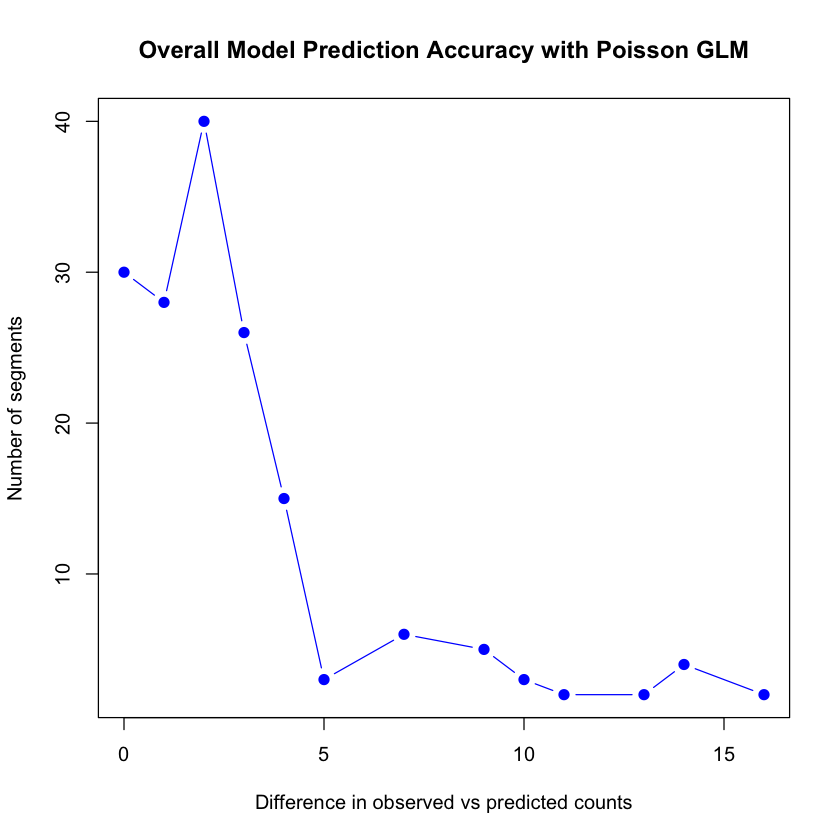

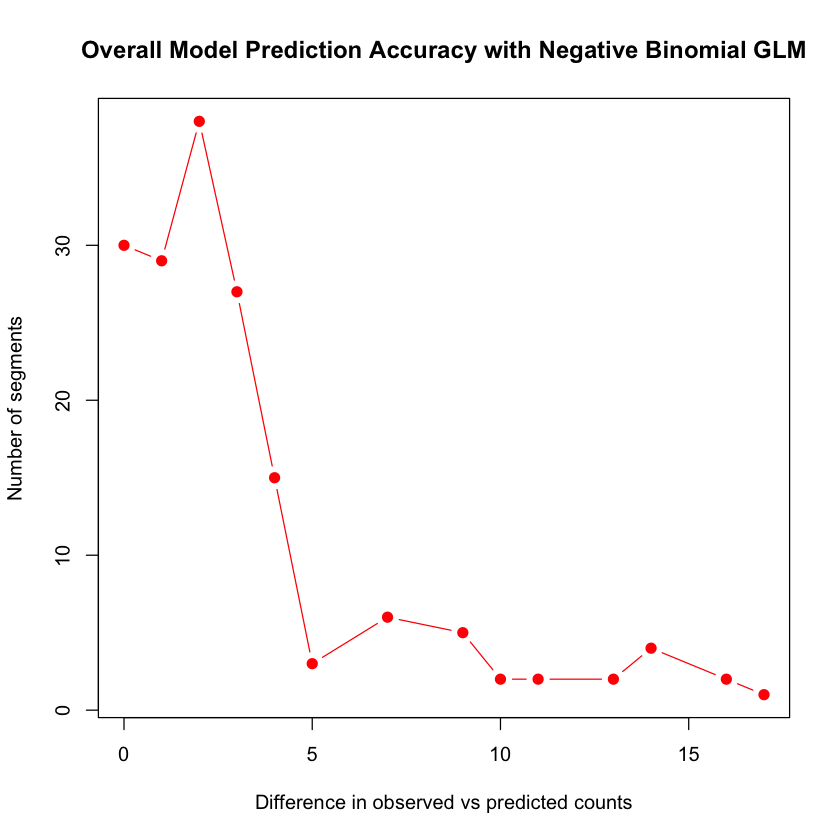

In [11]:
# If we consider AIC as a measure for goodness of fit for the different models, model 4 seems to be the best
# Therefore we try to predict the counts using negative binomial regression on annual counts
y_pred_model4 = predict(model4,test_data,type = "response")
y_pred_model3 = predict(model3,test_data,type = "response")
test_data$Predicted_glmnb_annual = y_pred_model4
test_data$Predicted_glm_annual = y_pred_model3
test_data$diff_counts1 = abs(round(test_data$MAG_Daily - test_data$Predicted_glmnb_annual,0))
test_data$diff_counts2 = abs(round(test_data$MAG_Daily - test_data$Predicted_glm_annual,0))
write.csv(test_data,"TBAG_predicted_results_annual.csv")
test_data$Count = 1
predicted_counts_grouped1 = aggregate(Count~diff_counts1,data=test_data,FUN=sum)
predicted_counts_grouped1 = subset(predicted_counts_grouped1,diff_counts1<20)
predicted_counts_grouped2 = aggregate(Count~diff_counts2,data=test_data,FUN=sum)
predicted_counts_grouped2 = subset(predicted_counts_grouped2,diff_counts2<20)
plot(predicted_counts_grouped2$diff_counts2,predicted_counts_grouped2$Count,
     main="Overall Model Prediction Accuracy with Poisson GLM",
     xlab="Difference in observed vs predicted counts",
     ylab = "Number of segments",pch=16,cex=1.25,type="b",col="blue")

plot(predicted_counts_grouped1$diff_counts1,predicted_counts_grouped1$Count,
     main="Overall Model Prediction Accuracy with Negative Binomial GLM",
     xlab="Difference in observed vs predicted counts",
     ylab = "Number of segments",pch=16,cex=1.25,type="b",col="red")

In [ ]:
#Find in sample prediction accuracy for MAG data
True_Counts = all_data_daily$MAG_Daily
Predicted_Counts = glm_output(all_data_daily[,-c(1)],all_data_daily[,-c(1)])
#Predicted_Counts = rpois(length(Predicted_Counts1), lambda = Predicted_Counts1)
plot(True_Counts,Predicted_Counts,pch=16,main="Poisson Model In-Sample Fit MAG data")
lmfit1 = lm(Predicted_Counts~True_Counts)
lmfit = lm(Predicted_Counts~True_Counts-1)
abline(lmfit1,col="red",lwd=3)
paste('R-squared:',round(summary(lmfit)$r.squared,4))   

In [ ]:
test_data = read.csv("TBAG_MonthlyCounts_Input_April26_run2.csv")
test_data = test_data[,-c(1,2,4,6,7,10,17,19,22,24,25,26)]
str(test_data)

In [ ]:
model7 = glm(MAG_Daily~.,data=test_data[,-c(1,2)],family=poisson(link=log))
summary(model7)

In [ ]:
1-

In [ ]:
exp(coef(model7))

In [ ]:
#Find in sample prediction accuracy for MAG data
True_Counts = test_data$MAG_Daily
Predicted_Counts = glm_output(test_data,test_data)
plot(True_Counts,Predicted_Counts,pch=16)
lmfit = lm(Predicted_Counts~True_Counts-1)
abline(lmfit,col="red",lwd=3)
legend("topleft",bty="n",legend = paste("R-squared:", round(summary(lmfit)$r.squared,3)))

In [ ]:
setwd('C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/Model Input')
newx = read.csv("Tempe_test_data_with_covariates.csv")
newx = data.frame(aggregate(.~edge_id+Month,newx,mean))
str(newx)

In [ ]:
newx_April = subset(newx,Month==4)
str(newx_April)

In [ ]:
newx_May = subset(newx,Month==5)
str(newx_May)

In [ ]:
newx_Oct = subset(newx,Month==10)
str(newx_Oct)

In [ ]:
newx_Nov = subset(newx,Month==11)
str(newx_Nov)

In [ ]:
Predicted_April = glm_output(test_data,newx_April[,c("edge_id","X","AADT","Avg_segment_speed_limit","dist_to_commercial_areas",
                                    "dist_to_green_space","dist_to_residential_areas",
                                    "Strava_Daily","Pop_per_sq_mile","PCT_WHITE_NONHISP",
                                    "PCT_VETERANS","MEDIAN_HOUSEHOLD_INCOME","PCT_BICYCLE")])
Predicted_May = glm_output(test_data,newx_May[,c("edge_id","X","AADT","Avg_segment_speed_limit","dist_to_commercial_areas",
                                    "dist_to_green_space","dist_to_residential_areas",
                                    "Strava_Daily","Pop_per_sq_mile","PCT_WHITE_NONHISP",
                                    "PCT_VETERANS","MEDIAN_HOUSEHOLD_INCOME","PCT_BICYCLE")])
Predicted_Oct = glm_output(test_data,newx_Oct[,c("edge_id","X","AADT","Avg_segment_speed_limit","dist_to_commercial_areas",
                                    "dist_to_green_space","dist_to_residential_areas",
                                    "Strava_Daily","Pop_per_sq_mile","PCT_WHITE_NONHISP",
                                    "PCT_VETERANS","MEDIAN_HOUSEHOLD_INCOME","PCT_BICYCLE")])
Predicted_Nov = glm_output(test_data,newx_Nov[,c("edge_id","X","AADT","Avg_segment_speed_limit","dist_to_commercial_areas",
                                    "dist_to_green_space","dist_to_residential_areas",
                                    "Strava_Daily","Pop_per_sq_mile","PCT_WHITE_NONHISP",
                                    "PCT_VETERANS","MEDIAN_HOUSEHOLD_INCOME","PCT_BICYCLE")])
#head(newx[,c("edge_id","Predicted_April","Predicted_May","Predicted_Oct","Predicted_Nov")])

In [ ]:
newx_April$Predicted = Predicted_April
newx_May$Predicted = Predicted_May
newx_Oct$Predicted = Predicted_Oct
newx_Nov$Predicted = Predicted_Nov

In [ ]:
write.csv(newx_April,"Tempe_Predicted_Counts_Apr.csv")
write.csv(newx_May,"Tempe_Predicted_Counts_May.csv")
write.csv(newx_Oct,"Tempe_Predicted_Counts_Oct.csv")
write.csv(newx_Nov,"Tempe_Predicted_Counts_Nov.csv")

In [ ]:
pred_val <- function(x)
    {
        if (x>10000)
        {
        yhat2 = round(rnorm(length(x),mean=x,sd=sqrt(x)),0)
        }
        else
        {
        yhat2 = rpois(length(x),lambda = x)
        }
    return(yhat2)
}

In [ ]:
newx$Pred_val = unlist(lapply(newx$Predicted,pred_val))

In [ ]:
df = data.frame(newx[,c('edge_id','Pred_val')])
head(df)

In [ ]:
nrow(subset(df,Pred_val>0 & Pred_val<2))

In [ ]:
setwd('C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/Model Output')
write.csv(df,"Tempe_Predicted_Counts_April28_run1.csv")

In [ ]:
#Overdispersion occurs for some of the predicted values

rpois.od<-function (n, lambda,d) {
  if (d==1)
    rpois(n, lambda)
  else
     rnbinom(n, size=(lambda/(d-1)), mu=lambda)
}

df = aggregate(Predicted_Counts~edge_id,street_segments_Tempe,mean)
df$"Predicted_Counts_actual" = rpois(length(df$"1"),lambda = df$"1")
head(df)

In [ ]:
errordf = model_error(test_data)
head(errordf)

In [ ]:
plot(errordf$test_size,errordf$rmse,pch=16,
     xlab="%Predicted segments",ylab="Root Mean Squared Error",
    main="Variation of Model Prediction Accuracy with Amount of test data")
lines(loess.smooth(errordf$test_size,errordf$rmse),col="red", lty=7, lwd=3)

In [ ]:
#Classify Predicted Volumes based on no of segments in each category
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import math
os.chdir("C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/Model Output")

# Divide the TBAG data into train-test split and predict the classes using svm classifier
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_curve,average_precision_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
def generate_confusion_matrix(X_train,y_train,X_test,y_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    classifier = svm.LinearSVC(random_state=0)
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print(cnf_matrix)
    return cnf_matrix

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

def assign_category1(x):
    if x in range(0,2):
        cat = 'VL'
    elif x in range(2,5):
        cat = 'L'
    elif x in range(5,35):
        cat = 'M'
    elif x in range(35,800):
        cat = 'H'
    else:
        cat = 'VH'
    return cat

def assign_category2(x):
    if x in range(0,2):
        cat = 'VL'
    elif x in range(2,10):
        cat = 'L'
    elif x in range(10,200):
        cat = 'M'
    elif x in range(200,900):
        cat = 'H'
    else:
        cat = 'VH'
    return cat

def assign_category3(x):
    if x in range(0,3):
        cat = 'VL'
    elif x in range(3,20):
        cat = 'L'
    elif x in range(20,450):
        cat = 'M'
    elif x in range(450,1200):
        cat = 'H'
    else:
        cat = 'VH'
    return cat

def assign_category4(x): 
    if x in range(0,5):
        cat = 'VL'
    elif x in range(5,55):
        cat = 'L'
    elif x in range(55,300):
        cat = 'M'
    elif x in range(300,1500):
        cat = 'H'
    else:
        cat = 'VH'
    return cat

def assign_category5(x):
    if x in range(0,20):
        cat = 'VL'
    elif x in range(20,150):
        cat = 'L'
    elif x in range(150,500):
        cat = 'M'
    elif x in range(500,2500):
        cat = 'H'
    else:
        cat = 'VH'
    return cat

def assign_category6(x):
    if x in range(0,50):
        cat = 'VL'
    elif x in range(50,500):
        cat = 'L'
    elif x in range(500,800):
        cat = 'M'
    elif x in range(800,1700):
        cat = 'H'
    else:
        cat = 'VH'
    return cat

In [ ]:
#Read predicted outcome for TBAG data from file
tbag_predicted = pd.read_csv("Tempe_Predicted_Counts_April28_run1.csv")[["edge_id","Pred_val"]]
tbag_predicted["Predicted"] = tbag_predicted.Pred_val
tbag_predicted.head()

In [ ]:
# Split the data into a training set and a test set
X = tbag_predicted
y = pd.DataFrame(tbag_predicted.Predicted)
y["category1"] = y.Predicted.apply(lambda x: assign_category1(x))
y["category2"] = y.Predicted.apply(lambda x: assign_category2(x))
y["category3"] = y.Predicted.apply(lambda x: assign_category3(x))
y["category4"] = y.Predicted.apply(lambda x: assign_category4(x))
y["category5"] = y.Predicted.apply(lambda x: assign_category5(x))
y["category6"] = y.Predicted.apply(lambda x: assign_category6(x))
classifier = svm.LinearSVC(random_state=0)
#Create class labels
class_names = ["High","Low","Medium","Very High","Very Low"]
# Create train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y.category1,test_size=0.15,random_state=1)

In [ ]:
#Generating classes for scenario 1
# VL : 0-2, L:2-5, M:5-35, H:35-800, VH:>800
print(y_test.groupby(y_test).count()/len(y_test))
X_train = np.array(X_train)
X_test = np.array(X_test)
#Assigning class labels to y
y_train_new = np.array(y_train)
y_test_new = np.array(y_test)

#Predict categories using the Classifier
y_pred = classifier.fit(X_train, y_train_new).predict(X_test)

# Compute confusion matrix
cnf1 = confusion_matrix(y_test_new, y_pred)
#print(cnf1)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf1, classes=class_names,title='Confusion matrix-Scenario1')
plt.show()
print("Score:",round(float(np.sum(cnf1.diagonal()))/float(np.sum(cnf1)),2))

In [ ]:
#Generating classes for scenario 2
# VL : 0-10, L:10-150, M:150-400, H:400-2500, VH:>2500
y_train_new = y.iloc[y_train.index,2]
y_test_new = y.iloc[y_test.index,2]
links_pct = y_test_new.groupby(y_test_new).count()/len(y_test_new)
print(links_pct)
#Assigning class labels to y
y_train_new = np.array(y_train_new)
y_test_new = np.array(y_test_new)

#Predict categories using the Classifier
y_pred = classifier.fit(X_train, y_train_new).predict(X_test)

# Compute confusion matrix
cnf2 = confusion_matrix(y_test_new, y_pred)
#print(cnf1)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf2, classes=class_names,title='Confusion matrix-Scenario2')
plt.show()
print("Score:",round(float(np.sum(cnf2.diagonal()))/float(np.sum(cnf2)),2))

In [ ]:
#Generating classes for scenario 3
# VL: 0-3, L:3-20, M:20-450, H:450-1200, VH:>1200
y_train_new = y.iloc[y_train.index,3]
y_test_new = y.iloc[y_test.index,3]
print(y_test_new.groupby(y_test_new).count()/len(y_test_new))

#Assigning class labels to y
y_train_new = np.array(y_train_new)
y_test_new = np.array(y_test_new)

#Predict categories using the Classifier
y_pred = classifier.fit(X_train, y_train_new).predict(X_test)

# Compute confusion matrix
cnf3 = confusion_matrix(y_test_new, y_pred)
#print(cnf3)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf3, classes=class_names,title='Confusion matrix-Scenario3')
plt.show()
print("Score:",round(float(np.sum(cnf3.diagonal()))/float(np.sum(cnf3)),2))

In [ ]:
#Generating classes for scenario 4
# VL : 0-5, L:5-55, M:55-700, H:700-3500, VH:>3500
y_train_new = y.iloc[y_train.index,4]
y_test_new = y.iloc[y_test.index,4]
print(y_test_new.groupby(y_test_new).count()/len(y_test_new))

#Assigning class labels to y
y_train_new = np.array(y_train_new)
y_test_new = np.array(y_test_new)

#Predict categories using the Classifier
y_pred = classifier.fit(X_train, y_train_new).predict(X_test)

# Compute confusion matrix
cnf4 = confusion_matrix(y_test_new, y_pred)
#print(cnf4)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf4, classes=class_names,title='Confusion matrix-Scenario4')
plt.show()
print("Score:",round(float(np.sum(cnf4.diagonal()))/float(np.sum(cnf4)),2))

In [ ]:
#Generating classes for scenario 5
# VL : 0-2, L:2-5, M:5-35, H:35-500, VH:>500
y_train_new = y.iloc[y_train.index,5]
y_test_new = y.iloc[y_test.index,5]
print(y_test_new.groupby(y_test_new).count()/len(y_test_new))

#Assigning class labels to y
y_train_new = np.array(y_train_new)
y_test_new = np.array(y_test_new)

#Predict categories using the Classifier
y_pred = classifier.fit(X_train, y_train_new).predict(X_test)

# Compute confusion matrix
cnf5 = confusion_matrix(y_test_new, y_pred)
#print(cnf4)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf5, classes=class_names,title='Confusion matrix-Scenario5')
plt.show()
print("Score:",round(float(np.sum(cnf5.diagonal()))/float(np.sum(cnf5)),2))

In [ ]:
#Generating classes for scenario 6
# VL : 0-200, L:200-500, M:500-1200, H:1200-3500, VH:>3500
y_train_new = y.iloc[y_train.index,6]
y_test_new = y.iloc[y_test.index,6]
print(y_test_new.groupby(y_test_new).count()/len(y_test_new))

#Assigning class labels to y
y_train_new = np.array(y_train_new)
y_test_new = np.array(y_test_new)

#Predict categories using the Classifier
y_pred = classifier.fit(X_train, y_train_new).predict(X_test)

# Compute confusion matrix
cnf6 = confusion_matrix(y_test_new, y_pred)
#print(cnf4)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf6, classes=class_names,title='Confusion matrix-Scenario6')
plt.show()
print("Score:",round(float(np.sum(cnf6.diagonal()))/float(np.sum(cnf6)),2))